# 1- Análise Exploratória e Pré-processamento

### 1.0 - Análise inicial

In [873]:
import pandas as pd
import matplotlib as plt
import numpy as np

# Pré processamento
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Supervisionada
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Nao Supervisionada
from sklearn.cluster import KMeans, AgglomerativeClustering

 # Metricas
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [874]:
df = pd.read_csv("data/akc-data-latest.csv")
df.head(3)

,Unnamed: 0,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly


Como 21 colunas é um número relativamente alto, seria interessante encontrar maneiras de reduzir a dimensionalidade dos dados

In [875]:
len(df)

277

277 é um número baixo de dados, pode ser que seja necessário fazer algum tipo de data augmentation ou oversample

In [876]:
# Exemplo de linha completa, com todas as colunas e seus respectivos valores
for column in df.columns:
    print(column + " - " + str(df.iloc[0][column]))

Unnamed: 0 - Affenpinscher
description - The Affen’s apish look has been described many ways. They’ve been called “monkey dogs” and “ape terriers.” The French say diablotin moustachu (“mustached little devil”), and Star Wars fans argue whether they look more like Wookies or Ewoks.Standing less than a foot tall, these sturdy terrier-like dogs approach life with great confidence. “This isn’t a breed you train,” a professional dog handler tells us, “He’s like a human. You befriend him.” The dense, harsh coat is described as “neat but shaggy” and comes in several colors; the gait is light and confident. They can be willful and domineering, but mostly Affens are loyal, affectionate, and always entertaining. Affen people say they love being owned by their little monkey dogs. The Affenpinscher: loyal, curious, and famously amusing; this almost-human toy dog is fearless out of all proportion to his size. As with all great comedians, it’s the Affenpinscher’s apparent seriousness of purpose that

In [877]:
df.describe()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
count,277.000000,277.000000,275.000000,275.000000,274.000000,274.000000,270.000000,257.000000,271.000000,253.000000,252.000000
mean,44.225801,52.720588,17.888858,27.291416,11.306569,13.832117,0.425926,0.529183,0.712915,0.624506,0.620635
std,14.238298,15.885454,12.290600,19.061416,1.817949,2.016668,0.198306,0.189068,0.168927,0.247271,0.201713
min,12.700000,17.780000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
25%,33.020000,38.100000,8.164663,12.927383,10.000000,13.000000,0.200000,0.400000,0.600000,0.400000,0.400000
50%,45.085000,53.340000,15.875733,24.947580,12.000000,14.000000,0.400000,0.600000,0.600000,0.600000,0.600000
75%,55.880000,66.040000,22.679619,34.019428,12.000000,15.000000,0.600000,0.600000,0.800000,0.800000,0.800000
max,76.200000,88.900000,68.038855,108.862169,16.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Aqui podemos perceber que as colunas min_weight, max_weight e max_expectancy possuem um ou mais elementos com valor 0, sendo esses dados inconsistentes seria interessante tratá-los

In [878]:
print(df["group"].value_counts())

group
Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               31
Working Group               31
Herding Group               30
Toy Group                   21
Non-Sporting Group          21
Miscellaneous Class         11
Name: count, dtype: int64


O nosso objetivo é tentar predizer o "group" de um objeto (supervisionado) e tentar agrupar objetos em torno dos grupos (não supervisionado). Aqui podemos perceber que as classes de grupo estão bastante desbalanceadas, então provavelmente algum tipo de oversample aqui ajudaria.

### 1.1 - Atributos que não serão utilizados

As colunas Unnamed: 0, description e popularity são únicas (ou perto disso) para cada elemento do dataset, logo não ajudarão no treinamento e podem ser removidas

In [879]:
df["Unnamed: 0"].value_counts()

Unnamed: 0
Affenpinscher                   1
Papillon                        1
Petit Basset Griffon Vendéen    1
Peruvian Inca Orchid            1
Perro de Presa Canario          1
                               ..
English Cocker Spaniel          1
English Foxhound                1
English Setter                  1
English Springer Spaniel        1
Yorkshire Terrier               1
Name: count, Length: 277, dtype: int64

In [880]:
df["description"].value_counts()

description
Poodles come in three size varieties: Standards should be more than 15 inches tall at the shoulder; Miniatures are 15 inches or under; Toys stand no more than 10 inches. All three varieties have the same build and proportions. At dog shows, Poodles are usually seen in the elaborate Continental Clip. Most pet owners prefer the simpler Sporting Clip, in which the coat is shorn to follow the outline of the squarely built, smoothly muscled body.Forget those old stereotypes of Poodles as sissy dogs. Poodles are eager, athletic, and wickedly smart “real dogs” of remarkable versatility. The Standard, with his greater size and strength, is the best all-around athlete of the family, but all Poodles can be trained with great success. Whether Standard, Miniature, or Toy, and either black, white, or apricot, the Poodle stands proudly among dogdom’s true aristocrats. Beneath the curly, low-allergen coat is an elegant athlete and companion for all reasons and seasons.                    

OBS: A descrição as vezes é bem semelhante para animais de mesma raça, sendo completamente igual apenas uma vez para o Poodle (Miniature) e Poodle (Standard) (no Poodle (Toy) ela já varia um pouco), porém muitas vezes isso não acontece e as descrições acabam sendo strings bem longas, portanto achei que seria complicado tentar manter algum tipo de relação entre as descrições para ajudar na predição e achei melhor apenas desconsiderar a coluna mesmo

In [881]:
df["popularity"].value_counts()

popularity
7      3
of     3
17     2
140    2
133    2
      ..
176    1
67     1
52     1
188    1
10     1
Name: count, Length: 191, dtype: int64

In [882]:
for _, element in df.loc[df["popularity"] == "7"].iterrows():
    print(element["group"])

Non-Sporting Group
Non-Sporting Group
Toy Group


In [883]:
for _, element in df.loc[df["popularity"] == "of"].iterrows():
    print(element["group"])

Hound Group
Sporting Group
Working Group


In [884]:
for _, element in df.loc[df["popularity"] == "17"].iterrows():
    print(element["group"])

Herding Group
Working Group


OBS: O popularity as vezes se repete, porém essas repetições não aparentam ter uma relação muito direta com o "group" que é o nosso label, achei melhor tirar junto com os outros 2

In [885]:
df_clean = df.drop(columns=["Unnamed: 0", "description", "popularity"])

### 1.2 - Temperament

Temperament é um caso a parte, pois poderia ser interessante mantê-la, porém para isso seria necessário splitar os adjetivos, organizá-los em listas e depois tokenizá-los para passar para o modelo (tokenizar direto criaria um valor para cada conjunto de 3 adjetivos e não para cada adjetivo individual, o que não ajudaria muio). Deixei para fazer isso apenas se os atributos selecionados não forem suficientes para alcançar um resultado satisfatório

In [886]:
# from sklearn.preprocessing import LabelEncoder

# PRIMEIRO PRECISARIA ORGANIZAR OS ADJETIVOS EM LISTAS DE ADJETIVOS

# le = LabelEncoder()
# df_clean['temperament'] = le.fit_transform(df_clean['temperament'])

In [887]:
df_clean["temperament"].value_counts()

temperament
Friendly, Smart, Willing to Please    3
Friendly, Alert, Intelligent          2
Loyal, Intelligent, Active            2
Loyal, Independent, Calm              2
Loyal, Alert, Intelligent             2
                                     ..
Intelligent, Lively, Athletic         1
Energetic, Merry, Responsive          1
Affectionate, Gentle, Sociable        1
Friendly, Mellow, Merry               1
Affectionate, Sprightly, Tomboyish    1
Name: count, Length: 267, dtype: int64

In [888]:
df_clean = df_clean.drop(columns=["temperament"])

### 1.x - Atributos redundantes

Para todos os campos de baixo, temos uma coluna que representa alguma característica por meio de classes e outra coluna que representa essa mesma característica numericamente, logo seria redundante manter os 2 por isso vou manter apenas o value e não o category (uma vez que já são valores númericos e normalizado de 0 - 1)

In [889]:
print(df_clean["grooming_frequency_value"].value_counts())
print()
print(df_clean["grooming_frequency_category"].value_counts())

grooming_frequency_value
0.4    119
0.2     75
0.6     50
0.8     18
1.0      8
Name: count, dtype: int64

grooming_frequency_category
Weekly Brushing              119
Occasional Bath/Brush         75
2-3 Times a Week Brushing     50
Daily Brushing                18
Specialty/Professional         8
Name: count, dtype: int64


In [890]:
print(df_clean["shedding_value"].value_counts())
print()
print(df_clean["shedding_category"].value_counts())

shedding_value
0.6    125
0.4     59
0.2     37
0.8     30
1.0      6
Name: count, dtype: int64

shedding_category
Seasonal      125
Occasional     59
Infrequent     37
Regularly      30
Frequent        6
Name: count, dtype: int64


In [891]:
print(df_clean["energy_level_value"].value_counts())
print()
print(df_clean["energy_level_category"].value_counts())

energy_level_value
0.6    118
0.8     92
1.0     41
0.4     19
0.2      1
Name: count, dtype: int64

energy_level_category
Regular Exercise          118
Energetic                  92
Needs Lots of Activity     41
Calm                       19
Couch Potato                1
Name: count, dtype: int64


In [892]:
print(df_clean["trainability_value"].value_counts())
print()
print(df_clean["trainability_category"].value_counts())

trainability_value
0.6    77
0.4    66
1.0    50
0.8    39
0.2    21
Name: count, dtype: int64

trainability_category
Agreeable          77
Independent        66
Eager to Please    50
Easy Training      39
May be Stubborn    21
Name: count, dtype: int64


In [893]:
print(df_clean["demeanor_value"].value_counts())
print()
print(df_clean["demeanor_category"].value_counts())

demeanor_value
0.8    77
0.6    75
0.4    73
1.0    19
0.2     8
Name: count, dtype: int64

demeanor_category
Friendly                   77
Alert/Responsive           75
Reserved with Strangers    73
Outgoing                   19
Aloof/Wary                  8
Name: count, dtype: int64


In [894]:
df_clean = df_clean.drop(columns=["grooming_frequency_category", "shedding_category", "energy_level_category", "trainability_category", "demeanor_category"])

### 1.x - Limpeza dos dados (duplicados, inconsistentes, outliers...)

Como não pretendia utilizar nenhuma das colunas dos passos anteriores, resolvi deixar para limpar o dataset depois da remoção delas, visto que tratar seus valores problemáticos seria inútil

In [895]:
df_clean.isna().sum()

min_height                   0
max_height                   0
min_weight                   2
max_weight                   2
min_expectancy               3
max_expectancy               3
group                        0
grooming_frequency_value     7
shedding_value              20
energy_level_value           6
trainability_value          24
demeanor_value              25
dtype: int64

In [896]:
df_clean.duplicated().sum()

1

Só temos um valor duplicado (provavelmente após a remoção das raças dos cachorros), porém ainda assim resolvi removê-lo.

In [897]:
# df_clean = df_clean.drop_duplicates()

Para as colunas de weight, expectancy, grooming e energy resolvi dropar as linhas com valores nan, por serem poucos.

In [898]:
# df_clean = df_clean.dropna(subset=["min_weight", "max_weight", "min_expectancy", "max_expectancy", "grooming_frequency_value", "energy_level_value"])

In [899]:
len(df_clean)

277

Já nas colunas de shedding, trainability e demeanor temos uma roporção alta de objetos com valores faltantes, nesses casos preferi não excluir esses elementos mas preenchê-los usando a média desses atributos.

In [900]:
for column in ["min_weight", "max_weight", "min_expectancy", "max_expectancy" ]:
    mean = df_clean[column].mean()
    
    df_clean[column] = df_clean[column].fillna(mean)

In [901]:
for column in ["grooming_frequency_value",
               "energy_level_value", "shedding_value", "trainability_value", "demeanor_value"]:
    median = df_clean[column].median()
    
    df_clean[column] = df_clean[column].fillna(median)

0.4
0.6
0.6
0.6
0.6


No final do processo, perdemos apenas 14 elementos dos 277 e conseguimos remover todos os nan

In [832]:
len(df_clean)

277

In [833]:
df_clean.isna().sum()

min_height                  0
max_height                  0
min_weight                  0
max_weight                  0
min_expectancy              0
max_expectancy              0
group                       0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
dtype: int64

### 1.5 - Correlação

Utilizei da correlação para realizar a redução de dimensionalidade final caso haja atributos com uma alta taxa de correlação

In [834]:
for column in df_clean.columns:
    print(column + " - " + str(df_clean.iloc[0][column]))

min_height - 22.86
max_height - 29.21
min_weight - 3.17514659
max_weight - 4.535923700000001
min_expectancy - 12.0
max_expectancy - 15.0
group - Toy Group
grooming_frequency_value - 0.6
shedding_value - 0.6
energy_level_value - 0.6
trainability_value - 0.8
demeanor_value - 1.0


In [835]:
corr = df_clean.corr(numeric_only=True)
corr.style.background_gradient(cmap="coolwarm")

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
min_height,1.000000,0.935146,0.814262,0.791436,-0.458785,-0.461913,-0.184157,0.280361,0.174401,-0.050567,-0.232882
max_height,0.935146,1.000000,0.791552,0.804923,-0.440156,-0.465925,-0.241068,0.315196,0.197246,-0.053547,-0.286522
min_weight,0.814262,0.791552,1.000000,0.947519,-0.537433,-0.547091,-0.135265,0.274301,-0.067172,-0.125497,-0.258487
max_weight,0.791436,0.804923,0.947519,1.000000,-0.511205,-0.520140,-0.113822,0.268933,-0.070947,-0.072217,-0.252366
min_expectancy,-0.458785,-0.440156,-0.537433,-0.511205,1.000000,0.765434,0.029371,-0.241117,0.000958,0.089529,0.175799
max_expectancy,-0.461913,-0.465925,-0.547091,-0.520140,0.765434,1.000000,0.124319,-0.340101,0.009723,0.091764,0.162765
grooming_frequency_value,-0.184157,-0.241068,-0.135265,-0.113822,0.029371,0.124319,1.000000,-0.070779,-0.146939,0.100454,0.114275
shedding_value,0.280361,0.315196,0.274301,0.268933,-0.241117,-0.340101,-0.070779,1.000000,0.166330,0.044169,-0.170594
energy_level_value,0.174401,0.197246,-0.067172,-0.070947,0.000958,0.009723,-0.146939,0.166330,1.000000,0.109109,0.002866
trainability_value,-0.050567,-0.053547,-0.125497,-0.072217,0.089529,0.091764,0.100454,0.044169,0.109109,1.000000,0.331615


Aqui podemos ver uma forte correlação entre as colunas de min e max (height, weight e expectancy), podendo ser interessante manter apenas o min ou o max (no describe percebi que o min sempre tinha uma variância menor do que o max, por isso escolhi ficar com o max pois ele poderia ser mais representativo das classes).

Também há uma boa correlação entre weight e height, logo também podemos escolher apenas uma das duas colunas para ficar (escolhi o weight pois tinha uma maior variância).

<b>OBS: Também há uma boa correlação negativa entre weight/height e expectancy, mas aqui ainda não decidi o que farei a respeito</b>

Aqui seria interessante fazer aquela estratégia de misturar esses atributos 2 a 2 no lugar de escolher apenas 1 para ficar.

In [836]:
df_clean = df_clean.drop(columns=["min_height", "max_height", "min_weight", "min_expectancy"])
# df_clean = df_clean.drop(columns=["min_height",  "min_weight", "min_expectancy"])

### 1.x - Oversampling e Split dos dados

In [837]:
df_clean.isna().sum()

max_weight                  0
max_expectancy              0
group                       0
grooming_frequency_value    0
shedding_value              0
energy_level_value          0
trainability_value          0
demeanor_value              0
dtype: int64

In [838]:
len(df_clean)

277

In [839]:
print(df_clean["group"].value_counts())

group
Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               31
Working Group               31
Herding Group               30
Toy Group                   21
Non-Sporting Group          21
Miscellaneous Class         11
Name: count, dtype: int64


Como já havia falado, não só temos poucos dados como as classes estão bem desbalanceadas, então para melhorar isso vou utilizar a técnica SMOTE de oversampling para aumentar a quantidade de dados e balanceá-los no processo.

Um detalhe é que o SMOTE só aceita valores numéricos, por isso antes de usá-lo eu faço uma conversão da coluna group usando o LabelEncoder do sklearn.

In [840]:
label_encoder = LabelEncoder()

group = label_encoder.fit_transform(df_clean["group"])

print(group)

group = pd.DataFrame(group, columns=['group'])

df_clean = df_clean.drop(columns=["group"])
df_clean = pd.merge(df_clean, group, left_index=True, right_index=True)
# df_clean["group"] = group

[7 2 6 8 8 0 2 4 2 6 0 6 5 8 0 1 0 1 0 6 2 5 2 0 2 0 2 1 1 6 3 1 1 1 1 1 8
 4 3 2 8 2 2 8 0 0 1 6 2 4 1 8 5 3 0 0 1 5 0 7 6 4 8 6 1 8 1 0 0 0 7 0 6 5
 7 7 4 8 4 2 5 5 1 4 0 5 0 2 4 6 0 0 8 8 8 0 0 3 5 2 5 5 7 1 0 0 5 1 4 5 4
 0 0 8 1 5 0 5 8 6 5 5 2 8 8 8 2 0 0 2 7 0 0 2 1 5 5 6 5 2 7 0 7 0 0 0 0 4
 6 0 8 0 8 5 5 6 3 0 8 4 4 7 6 7 8 1 6 7 6 0 3 8 5 8 6 3 1 2 4 6 5 1 2 7 6
 7 1 0 3 2 2 2 5 1 7 4 4 7 0 3 2 0 0 8 0 7 1 1 0 1 0 6 2 2 0 8 6 3 0 8 2 8
 0 4 2 6 6 0 1 4 7 0 8 7 6 2 0 0 0 0 6 6 0 1 5 0 6 8 5 0 1 0 3 0 8 4 4 0 0
 7 0 0 2 5 5 5 6 6 0 2 6 5 5 0 4 0 7]


In [841]:
smote = SMOTE(random_state=0)

In [842]:
# Aqui eu separo os dados entre atributos e target, essas duas variáveis serão utilizadas ao longo de todo o notebook
X = df_clean.drop(columns=["group"])
y = df_clean["group"]

In [843]:
# Aplicação do SMOTE e conversão de volta para dataframe
X_resampled, y_resampled = smote.fit_resample(X, y)

X = pd.DataFrame(X_resampled, columns=X.columns)
y = pd.DataFrame(y_resampled, columns=['group'])

# Aqui eu atualizei o df_clean só para mostrar os dados dele mesmo, nos treinamentos será sempre usado só o X e y
df_clean = pd.merge(X, y, left_index=True, right_index=True)

# Algumas funções esperam que o y seja apenas um vetor e não funcionam tão bem com ele sendo um dataframe
y = y["group"]


In [844]:
# Agora temos um número de elementos maior
len(df_clean)

612

In [845]:
# group agora está com as classes devidamente balanceadas
df_clean["group"].value_counts()

group
7    68
2    68
6    68
8    68
0    68
4    68
5    68
1    68
3    68
Name: count, dtype: int64

In [846]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) holdout de 20%

Aqui é instanciado o skf, que será utilizado para realizar a validação cruzada nos modelos

In [847]:
# Stratified 10 fold cross validation, será utilizado para realizar a validação cruzada dos modelos
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# 2 - Aprendizagem supervisionada

In [848]:
for column in df_clean.columns:
    print(column + " - " + str(df_clean.iloc[0][column]))

max_weight - 4.535923700000001
max_expectancy - 15.0
grooming_frequency_value - 0.6
shedding_value - 0.6
energy_level_value - 0.6
trainability_value - 0.8
demeanor_value - 1.0
group - 7.0


In [849]:
corr = df_clean.corr(numeric_only=True)
corr.style.background_gradient(cmap="coolwarm")

,max_weight,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,group
max_weight,1.000000,-0.623478,-0.128214,0.308110,0.053118,-0.043470,-0.289217,-0.035851
max_expectancy,-0.623478,1.000000,0.150309,-0.418271,-0.020526,0.084259,0.227455,0.019206
grooming_frequency_value,-0.128214,0.150309,1.000000,-0.127397,-0.185382,0.052481,0.145973,0.249723
shedding_value,0.308110,-0.418271,-0.127397,1.000000,0.200419,0.039047,-0.265521,-0.106228
energy_level_value,0.053118,-0.020526,-0.185382,0.200419,1.000000,0.151418,-0.055974,-0.104607
trainability_value,-0.043470,0.084259,0.052481,0.039047,0.151418,1.000000,0.316536,-0.004023
demeanor_value,-0.289217,0.227455,0.145973,-0.265521,-0.055974,0.316536,1.000000,0.233493
group,-0.035851,0.019206,0.249723,-0.106228,-0.104607,-0.004023,0.233493,1.000000


Finalizado o nosso pré-processamento, ficamos com apenas 8 atributos (sendo um deles o próprio label) dos 21 iniciais, tendo eles pouca correlação entre si, também temos um volume consideravelmente maior de dados (277 para 612) que agora estão balanceados em cima do group, sendo essa uma conjuntura bem melhor para os modelos, resta saber se esses atributos serão suficientes para representar bem os nossos dados.

### 2.1 - Árvore de Decisão

In [850]:
clf = DecisionTreeClassifier(random_state=0)

In [851]:
y_test_tree = []
y_pred_tree = []

acc_tree = []
f1_tree = []

# Treinamento e validação em cima dos folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treinamento e validação
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_test_tree.append(y_test)
    y_pred_tree.append(y_pred)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    acc_tree.append(acc)

    f1 = f1_score(y_test, y_pred, average='weighted') 
    f1_tree.append(f1)

In [852]:
for i in range (10):
    print(f'Accuracy do fold {i}: {acc_tree[i]}')

mean_acc_score = sum(acc_tree) / len(acc_tree)
print(f'\nAccuracy média: {mean_acc_score}')

Accuracy do fold 0: 0.6774193548387096
Accuracy do fold 1: 0.6774193548387096
Accuracy do fold 2: 0.6065573770491803
Accuracy do fold 3: 0.7049180327868853
Accuracy do fold 4: 0.7377049180327869
Accuracy do fold 5: 0.6229508196721312
Accuracy do fold 6: 0.6721311475409836
Accuracy do fold 7: 0.7377049180327869
Accuracy do fold 8: 0.5901639344262295
Accuracy do fold 9: 0.5245901639344263

Accuracy média: 0.6551560021152828


In [853]:
for i in range (10):
    print(f'F1-score do fold {i}: {f1_tree[i]}')

mean_f1_score = sum(f1_tree) / len(f1_tree)
print(f'\nF1-score médio: {mean_f1_score}')

F1-score do fold 0: 0.6788856304985338
F1-score do fold 1: 0.6783297505783276
F1-score do fold 2: 0.6028163093736865
F1-score do fold 3: 0.7027573198257865
F1-score do fold 4: 0.7379214592329345
F1-score do fold 5: 0.6017420702088011
F1-score do fold 6: 0.6612060071076464
F1-score do fold 7: 0.7277106773008413
F1-score do fold 8: 0.5886944701071992
F1-score do fold 9: 0.5294986996288829

F1-score médio: 0.6509562393862639


Selecione o fold a ser representado na matriz por meio da variável fold

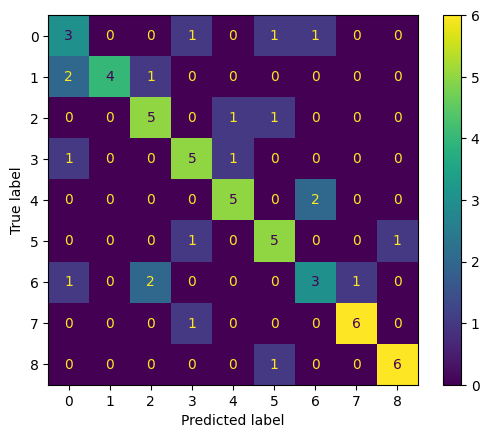

In [854]:
fold = 0

cm = confusion_matrix(y_test_tree[fold], y_pred_tree[fold])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### 2.2 - Naive Bayes

In [855]:
gnb = GaussianNB()

In [856]:
y_test_gnb = []
y_pred_gnb = []

acc_gnb = []
f1_gnb = []

# Treinamento e validação em cima dos folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treinamento e validação
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)

    y_test_gnb.append(y_test)
    y_pred_gnb.append(y_pred)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    acc_gnb.append(acc)

    f1 = f1_score(y_test, y_pred, average='weighted') 
    f1_gnb.append(f1)

In [857]:
for i in range (10):
    print(f'Accuracy do fold {i}: {acc_gnb[i]}')

mean_acc_score = sum(acc_gnb) / len(acc_gnb)
print(f'\nAccuracy média: {mean_acc_score}')

Accuracy do fold 0: 0.43548387096774194
Accuracy do fold 1: 0.41935483870967744
Accuracy do fold 2: 0.36065573770491804
Accuracy do fold 3: 0.45901639344262296
Accuracy do fold 4: 0.5573770491803278
Accuracy do fold 5: 0.45901639344262296
Accuracy do fold 6: 0.4918032786885246
Accuracy do fold 7: 0.45901639344262296
Accuracy do fold 8: 0.5081967213114754
Accuracy do fold 9: 0.39344262295081966

Accuracy média: 0.4543363299841355


In [858]:
for i in range (10):
    print(f'F1-score do fold {i}: {f1_gnb[i]}')

mean_f1_score = sum(f1_gnb) / len(f1_gnb)
print(f'\nF1-score médio: {mean_f1_score}')

F1-score do fold 0: 0.403698567930067
F1-score do fold 1: 0.38411727632865156
F1-score do fold 2: 0.34104143500682105
F1-score do fold 3: 0.42872283614810136
F1-score do fold 4: 0.5450453965553189
F1-score do fold 5: 0.38524882382163
F1-score do fold 6: 0.46606926770861196
F1-score do fold 7: 0.4406263135771333
F1-score do fold 8: 0.5069841842503366
F1-score do fold 9: 0.3556787742419372

F1-score médio: 0.4257232875568609


Selecione o fold a ser representado na matriz por meio da variável fold

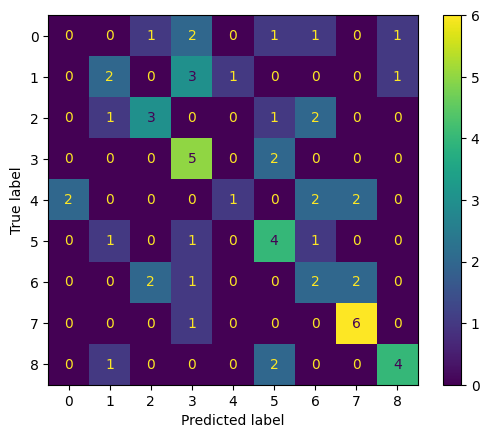

In [859]:
fold = 0

cm = confusion_matrix(y_test_gnb[fold], y_pred_gnb[fold])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### 2.3 - MLP

In [902]:
mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(50,) ,max_iter=2000)

In [903]:
y_test_mlp = []
y_pred_mlp = []

acc_mlp = []
f1_mlp = []

# Treinamento e validação em cima dos folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treinamento e validação
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    y_test_mlp.append(y_test)
    y_pred_mlp.append(y_pred)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    acc_mlp.append(acc)

    f1 = f1_score(y_test, y_pred, average='weighted') 
    f1_mlp.append(f1)

In [862]:
for i in range (10):
    print(f'Accuracy do fold {i}: {acc_mlp[i]}')

mean_acc_score = sum(acc_mlp) / len(acc_mlp)
print(f'\nAccuracy média: {mean_acc_score}')

Accuracy do fold 0: 0.5645161290322581
Accuracy do fold 1: 0.6290322580645161
Accuracy do fold 2: 0.5081967213114754
Accuracy do fold 3: 0.5737704918032787
Accuracy do fold 4: 0.6065573770491803
Accuracy do fold 5: 0.5081967213114754
Accuracy do fold 6: 0.5409836065573771
Accuracy do fold 7: 0.6557377049180327
Accuracy do fold 8: 0.6721311475409836
Accuracy do fold 9: 0.639344262295082

Accuracy média: 0.5898466419883659


In [904]:
for i in range (10):
    print(f'F1-score do fold {i}: {f1_mlp[i]}')

mean_f1_score = sum(f1_mlp) / len(f1_mlp)
print(f'\nF1-score médio: {mean_f1_score}')

F1-score do fold 0: 0.557820136852395
F1-score do fold 1: 0.558756297465975
F1-score do fold 2: 0.5392328179695585
F1-score do fold 3: 0.5980276554047045
F1-score do fold 4: 0.4854274141159386
F1-score do fold 5: 0.44805905576600397
F1-score do fold 6: 0.5554268296794815
F1-score do fold 7: 0.6640201435765563
F1-score do fold 8: 0.6450318967435651
F1-score do fold 9: 0.5621727998777178

F1-score médio: 0.5613975047451896


Selecione o fold a ser representado na matriz por meio da variável fold

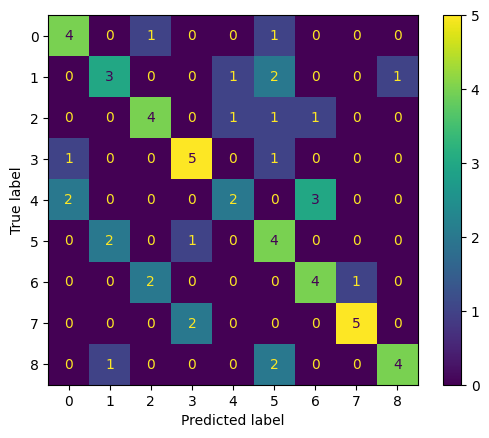

In [864]:
fold = 0

cm = confusion_matrix(y_test_mlp[fold], y_pred_mlp[fold])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# 3 - Aprendizagem Não Supervisionada

In [865]:
# df_clean = df_clean.drop(columns=["group"]) só usar o X

### 3.2 - Teste do cotovoelo

### 3.1 - K-means

https://medium.com/data-folks-indonesia/step-by-step-to-understanding-k-means-clustering-and-implementation-with-sklearn-b55803f519d6

In [866]:
kmeans = KMeans(n_clusters=9, random_state=0)

In [867]:
kmeans.fit(X)
kmeans_labels = kmeans.labels_

In [868]:
# Suponha que 'labels_true' são as etiquetas verdadeiras do seu conjunto de dados

# Calcular a silhueta
silhouette = silhouette_score(X, kmeans_labels)
print("Silhouette Score:", silhouette)

# Calcular a inércia (para o K-means)
inertia = kmeans.inertia_
print("Inertia:", inertia)

# Calcular o índice de Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(X, kmeans_labels)
print("Calinski-Harabasz Score:", calinski_harabasz)

# Calcular o índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, kmeans_labels)
print("Davies-Bouldin Score:", davies_bouldin)

# Calcular homogeneidade, completude e V-measure
homogeneity = homogeneity_score(y, kmeans_labels)
completeness = completeness_score(y, kmeans_labels)
v_measure = v_measure_score(y, kmeans_labels)

print("Homogeneity Score:", homogeneity)
print("Completeness Score:", completeness)
print("V-Measure Score:", v_measure)


Silhouette Score: 0.4676346469241193
Inertia: 5301.098076596473
Calinski-Harabasz Score: 2731.802508636798
Davies-Bouldin Score: 0.6252235293864806
Homogeneity Score: 0.2671728414271552
Completeness Score: 0.2956258302312949
V-Measure Score: 0.28068009766053603


### 3.2 - Hierárquico

In [869]:
hierarquico_ward = AgglomerativeClustering(n_clusters=9, linkage="ward")
hierarquico_complete = AgglomerativeClustering(n_clusters=9, linkage="complete")

In [870]:
hierarquico_ward.fit(X)
hierarquico_ward_labels = hierarquico_ward.labels_

hierarquico_complete.fit(X)
hierarquico_complete_labels = hierarquico_complete.labels_

In [871]:
print("Ward")
# Suponha que 'labels_true' são as etiquetas verdadeiras do seu conjunto de dados

# Calcular a silhueta
silhouette = silhouette_score(X, hierarquico_ward_labels)
print("Silhouette Score:", silhouette)

# Calcular a inércia (para o K-means)
inertia = kmeans.inertia_
print("Inertia:", inertia)

# Calcular o índice de Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(X, hierarquico_ward_labels)
print("Calinski-Harabasz Score:", calinski_harabasz)

# Calcular o índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, hierarquico_ward_labels)
print("Davies-Bouldin Score:", davies_bouldin)

# Calcular homogeneidade, completude e V-measure
homogeneity = homogeneity_score(y, hierarquico_ward_labels)
completeness = completeness_score(y, hierarquico_ward_labels)
v_measure = v_measure_score(y, hierarquico_ward_labels)

print("Homogeneity Score:", homogeneity)
print("Completeness Score:", completeness)
print("V-Measure Score:", v_measure)


Ward
Silhouette Score: 0.48091597089238985
Inertia: 5301.098076596473
Calinski-Harabasz Score: 2759.9383693118357
Davies-Bouldin Score: 0.5643277629577094
Homogeneity Score: 0.25871862987049754
Completeness Score: 0.30608689081178475
V-Measure Score: 0.28041645526581943


In [872]:
print("Complete")
# Suponha que 'labels_true' são as etiquetas verdadeiras do seu conjunto de dados

# Calcular a silhueta
silhouette = silhouette_score(X, hierarquico_complete_labels)
print("Silhouette Score:", silhouette)

# Calcular a inércia (para o K-means)
inertia = kmeans.inertia_
print("Inertia:", inertia)

# Calcular o índice de Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(X, hierarquico_complete_labels)
print("Calinski-Harabasz Score:", calinski_harabasz)

# Calcular o índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, hierarquico_complete_labels)
print("Davies-Bouldin Score:", davies_bouldin)

# Calcular homogeneidade, completude e V-measure
homogeneity = homogeneity_score(y, hierarquico_complete_labels)
completeness = completeness_score(y, hierarquico_complete_labels)
v_measure = v_measure_score(y, hierarquico_complete_labels)

print("Homogeneity Score:", homogeneity)
print("Completeness Score:", completeness)
print("V-Measure Score:", v_measure)


Complete
Silhouette Score: 0.44075293798566667
Inertia: 5301.098076596473
Calinski-Harabasz Score: 2160.0410764832186
Davies-Bouldin Score: 0.615967954215049
Homogeneity Score: 0.2448964485381067
Completeness Score: 0.3064983502016125
V-Measure Score: 0.27225631296749075
